<a href="https://colab.research.google.com/github/patbolan/MPHY5178_F22/blob/main/Bloch_Simulation/simulate_fid_bloch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Bloch simulator
Using a Runge-Kutta ODE solver, as in MPHY5178


In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# Define Bloch derivatives dM/dt
def dMdt_function(b1x, b1y, R1, R2, Omega, M):
  dMdt = np.zeros([3], float)

  dMdt[0] = (Omega * M[1]) - (b1y*M[2]) - (M[0]*R2)
  dMdt[1] = (b1x*M[2]) - (Omega*M[0]) - (M[1]*R2)
  dMdt[2] = (b1y*M[0]) - (b1x*M[1]) + ((1. - M[2]) *R1)

  return dMdt

In [9]:
# Define bloch estimation using Runge-Kutta 4th order ODE solver
# Good reference: https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19690021375.pdf
def bloch_RK4(Minit, b1x, b1y, Omega, R1, R2, dT):
  KK = np.zeros([4,3], float)

  KK[0,:] = dT * dMdt_function(b1x, b1y, R1, R2, Omega, Minit)
  KK[1,:] = dT * dMdt_function(b1x, b1y, R1, R2, Omega, Minit + KK[0,:]/2)
  KK[2,:] = dT * dMdt_function(b1x, b1y, R1, R2, Omega, Minit + KK[1,:]/2)
  KK[3,:] = dT * dMdt_function(b1x, b1y, R1, R2, Omega, Minit + KK[2,:])
  
  Mnext = Minit + (1./6.) * (KK[0,:] + 2. * KK[1,:] + 2. * KK[2,:] + KK[3,:])
  return Mnext

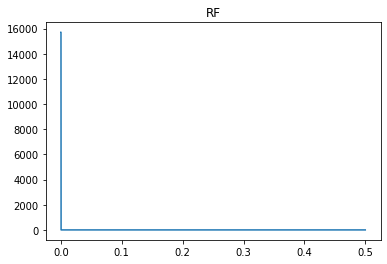

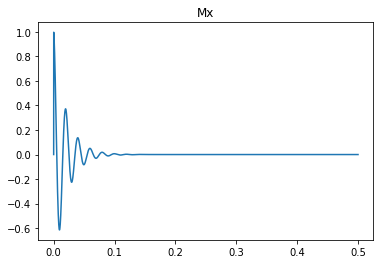

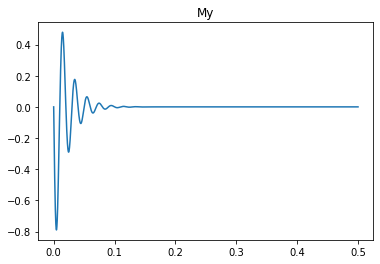

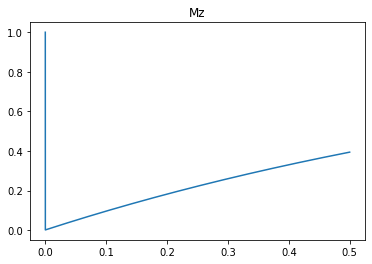

In [10]:
pulse_duration = 0.0001 # seconds
flip_angle = 90 # degrees
simulation_duration = 0.5
dT = 0.000001 # Time resolution for simulation. Needs to be finer than pulse_duration
# PJB Change: using arange and simulation_duration to make this clearer!
#timeaxis = np.linspace(0, 0.5, np.int(0.5/dT+1))
timeaxis = np.arange(0, simulation_duration, dT)
Nt = timeaxis.shape[0]

T1 = 1.0 # seconds
T2 = 0.020 # seconds
offset = 50 * 2. * np.pi # off-resonance, converted to rad/s

b1_max = flip_angle/180. * 500.* (0.001 / pulse_duration) * 2. * np.pi
b1y = timeaxis * 0
b1y[timeaxis<pulse_duration] = -b1_max # nice, logical indexing just like Matlab!
b1x = b1y * 0

Mt = np.zeros([Nt,3], float) # M(t)
Mt[0,:] = [0,0,1] # Initial value M(t) = M0 z

# Step through all timepoints
for idx in range(1, Nt):
    Mt[idx,:] = bloch_RK4(Mt[idx-1,:], b1x[idx], b1y[idx], offset, 1/T1, 1/T2, dT)

# Plot the results
plt.plot(timeaxis, -b1y)
plt.title('RF')
plt.show()    
    
plt.plot(timeaxis, Mt[:,0])
plt.title('Mx')
plt.show()

plt.plot(timeaxis, Mt[:,1])
plt.title('My')
plt.show()

plt.plot(timeaxis, Mt[:,2])
plt.title('Mz')
plt.show()


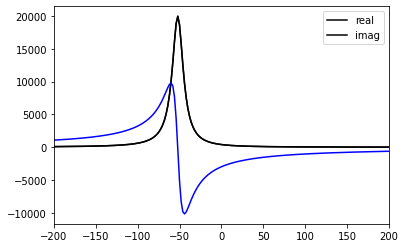

In [11]:
# Extract the signal. 
s = Mt[:,0]+ 1j*Mt[:,1]

# Only take the part after the pulse
s = s[timeaxis>pulse_duration]
t_fid = timeaxis[timeaxis>pulse_duration]

# Before a FT we scale the first point of an FID by 1/2. This is a subtle 
# effect that is often ignored. (G Otting et al, JMR 66 p187 1986)
s_temp = s
s_temp[0] = s_temp[0] * 0.5
spec = np.fft.fftshift(np.fft.fft(s_temp))

# Calculate frequency axis
SW = 1/dT
Npoints = len(t_fid)
dFreq = SW/(Npoints)
freqax = np.arange(-SW/2, SW/2, dFreq) - dFreq/2
plt.plot(freqax,np.real(spec), 'k')

plt.plot(freqax,np.real(spec), 'k')
plt.plot(freqax,np.imag(spec), 'b')
plt.legend(['real', 'imag'])
plt.xlim([-200, 200])
plt.show()